# EP1 - Paralelizando o Cálculo do Conjunto de Mandelbrot com Pthreads e OpenMP

## Integrantes

| Nome | NUSP |
|------|------|
| Iggor Francis Numata Matthews | 10262572 |
| João Gabriel Loureiro de Lima Lembo | 10737178 |
| Otávio Ho Aragoni | 9793798 |
| Victor Pereira Lima| 10737028 |


In [ ]:
] up

Verifique o status dos pacotes, e se há algum problema, com o comando:

In [ ]:
] st

In [ ]:
; bash run_measurements.sh

# READ LOG TO DATAFRAME HERE

In [1]:
import Base.read
import Pkg
Pkg.add("DataFrames")
Pkg.add("Query")
Pkg.add("StatsPlots")
Pkg.add("Distributions")
Pkg.add("Statistics")
Pkg.add("PGFPlotsX")

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching: [================>                        ]  

Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`


In [2]:
using DataFrames, Query, StatsPlots, Statistics

function readingSeqFiles(figure)
    resultsPath = "$(@__DIR__)/results"
    
    results = DataFrame(size = Int[],
        io_time = Float64[],
        allocation_time = Float64[],
        full_time = Float64[])  
    
    filepath = "$(resultsPath)/mandelbrot_seq/$(figure).log"
    open(filepath) do f
        while !eof(f)
            line = readline(f)
            lineArray = split(line, ' ')
            if lineArray[1] == "Info" 
                imageSize = parse(Int64, lineArray[3])
                measurements = parse(Int64, lineArray[4])
                for i in 1:measurements
                    line = split(readline(f), ' ')
                    append!(results, DataFrame(size = imageSize,
                                               io_time = parse(Float64, line[1]),
                                               allocation_time = parse(Float64, line[2]),
                                               full_time = parse(Float64, line[3])))
                end
            end
        end
    end
    return results
end

readingSeqFiles (generic function with 1 method)

In [3]:
function parse_seq_results(results)
    parsed_results = results |>
                    @groupby(_.size) |>
                    @map({size = key(_),
                          mean_io_estimate = mean(_.io_time),
                          ci_io_estimate = 1.96 * std(_.io_time),
                          mean_alloc_estimate = mean(_.allocation_time),
                          ci_alloc_estimate = 1.96 * std(_.allocation_time),
                          mean_full_estimate = mean(_.full_time),
                          ci_full_estimate = 1.96 * std(_.full_time)}) |>
                    DataFrame
    
    return parsed_results
end

parse_seq_results (generic function with 1 method)

In [4]:
pgfplotsx()

function plot_seq_results(x, y, title, yerror = [], min_size = 0, max_size = 16)      
        p = scatter(x,
            y,
            title = title,
            xaxis = :log2,
            xlabel = "Tamanho da Entrada",
            xticks = [2 ^ x for x in min_size:max_size],
            yerror = yerror,
            alpha = 0.6,
            legend = :topright)
    
    return p
end

plot_seq_results (generic function with 4 methods)

In [5]:
function readingThreadFiles(figure, size, thread_type)
    resultsPath = "$(@__DIR__)/results"
    
    results = DataFrame(size = Int[],
                        threads = Int[],
                        full_time = Float64[])  
    
    filepath = "$(resultsPath)/mandelbrot_$(thread_type)/$(figure).log"
    open(filepath) do f
        while !eof(f)
            line = readline(f)
            lineArray = split(line, ' ')
            if lineArray[1] == "Info"
                if parse(Int64, lineArray[3]) == size
                    imageSize = size
                    threads = parse(Int64, lineArray[2])
                    measurements = parse(Int64, lineArray[4])
                    for i in 1:measurements
                        line = split(readline(f), ' ')
                        append!(results, DataFrame(size = imageSize,
                                                   threads = threads,
                                                   full_time = parse(Float64, line[1])))
                    end
                end
            end
        end
    end
    return results
end

readingThreadFiles (generic function with 1 method)

In [6]:
function parse_thread_results(results)
    parsed_results = results |>
                    @groupby(_.threads) |>
                    @map({threads = key(_),
                          mean_estimate = mean(_.full_time),
                          ci_estimate = 1.96 * std(_.full_time)}) |>
                    DataFrame
    
    return parsed_results
end

parse_thread_results (generic function with 1 method)

In [7]:
function plot_thread_results(x, y, title, yerror = [], min_thread_power = 0, max_thread_power = 16)      
        p = scatter(x,
            y,
            title = title,
            xaxis = :log2,
            xlabel = "Número de Threads",
            xticks = [2 ^ x for x in min_thread_power:max_thread_power],
            yerror = yerror,
            alpha = 0.6,
            legend = :topright)
    
    return p
end

plot_thread_results (generic function with 4 methods)

## Análise do Programa Sequencial

Primeiramente, vamos utilizar os resultados obtidos nas execuções do programa sequencial para analisar as diferenças entre as quatro diferentes regiões calculadas e também analisar a influência das operações de IO e de alocação de memória.

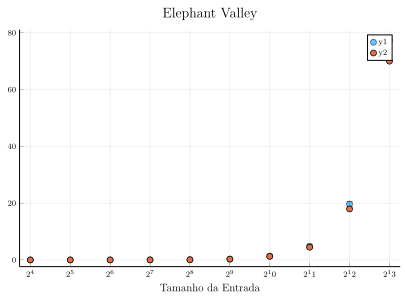

In [8]:
elephant_results = readingSeqFiles("elephant")
elephant_parsed_results = parse_seq_results(elephant_results)

elephant_real_mean = (elephant_parsed_results.mean_full_estimate .- elephant_parsed_results.mean_io_estimate
                     .- elephant_parsed_results.mean_alloc_estimate)

plot_seq_results(elephant_parsed_results.size, elephant_parsed_results.mean_full_estimate, "Elephant Valley",
                    elephant_parsed_results.ci_full_estimate, 4, 13)

scatter!(elephant_parsed_results.size, elephant_real_mean)

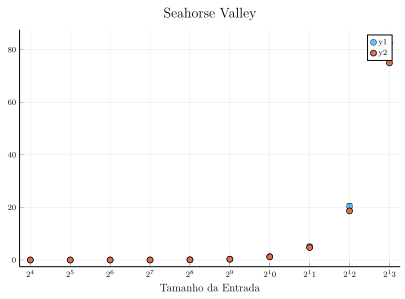

In [9]:
seahorse_results = readingSeqFiles("seahorse")
seahorse_parsed_results = parse_seq_results(seahorse_results)

seahorse_real_mean = (seahorse_parsed_results.mean_full_estimate .- seahorse_parsed_results.mean_io_estimate
                     .- seahorse_parsed_results.mean_alloc_estimate)

plot_seq_results(seahorse_parsed_results.size, seahorse_parsed_results.mean_full_estimate, "Seahorse Valley",
                    seahorse_parsed_results.ci_full_estimate, 4, 13)

scatter!(seahorse_parsed_results.size, seahorse_real_mean)

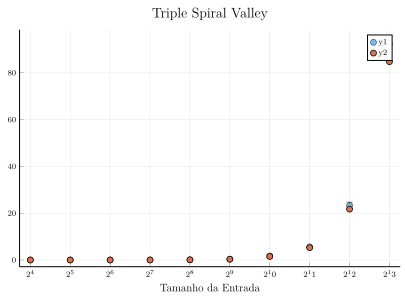

In [10]:
triple_spiral_results = readingSeqFiles("triple_spiral")
triple_spiral_parsed_results = parse_seq_results(triple_spiral_results)

triple_spiral_real_mean = (triple_spiral_parsed_results.mean_full_estimate .- triple_spiral_parsed_results.mean_io_estimate
                     .- triple_spiral_parsed_results.mean_alloc_estimate)

plot_seq_results(triple_spiral_parsed_results.size, triple_spiral_parsed_results.mean_full_estimate, "Triple Spiral Valley",
                    triple_spiral_parsed_results.ci_full_estimate, 4, 13)

scatter!(triple_spiral_parsed_results.size, triple_spiral_real_mean)

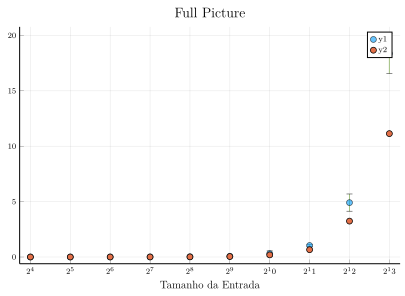

In [11]:
full_results = readingSeqFiles("full")
full_parsed_results = parse_seq_results(full_results)

full_real_mean = (full_parsed_results.mean_full_estimate .- full_parsed_results.mean_io_estimate
                     .- full_parsed_results.mean_alloc_estimate)

plot_seq_results(full_parsed_results.size, full_parsed_results.mean_full_estimate, "Full Picture",
                    full_parsed_results.ci_full_estimate, 4, 13)

scatter!(full_parsed_results.size, full_real_mean)

#### Diferenças entre as Regiões

#### Análise de I/O e Alocação de Memória

## Análise do Programa Paralelizado com Pthreads

Agora, vamos analisar o desempenho do programa paralelizado utilizando a biblioteca Pthreads. Vamos comparar as diferenças para as diferentes regiões, mas também, e principalmente, as diferenças no tempo de execução baseado no número de threads utilizadas. Vamos considerar nas análises também o tamanho da entrada.

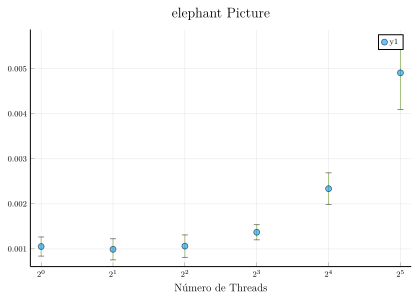

In [22]:
elephant_results = readingThreadFiles("elephant", 16, "pth")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

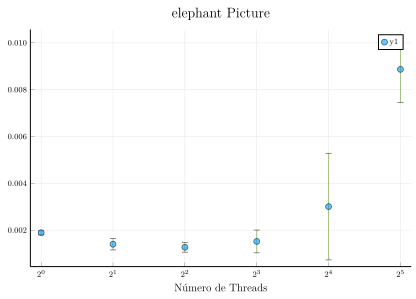

In [23]:
elephant_results = readingThreadFiles("elephant", 32, "pth")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

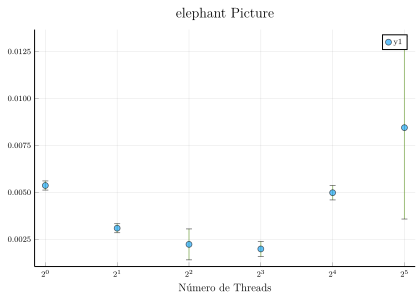

In [24]:
elephant_results = readingThreadFiles("elephant", 64, "pth")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

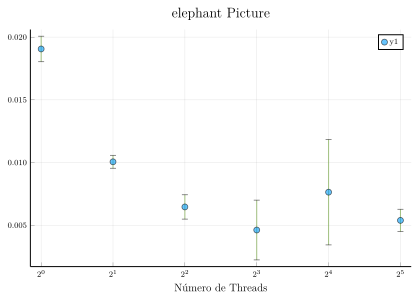

In [25]:
elephant_results = readingThreadFiles("elephant", 128, "pth")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

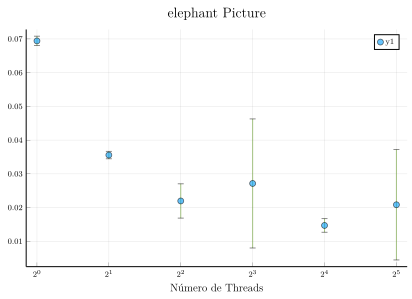

In [26]:
elephant_results = readingThreadFiles("elephant", 256, "pth")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

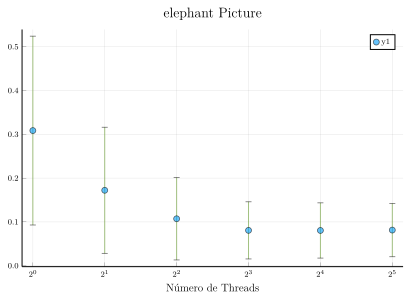

In [27]:
elephant_results = readingThreadFiles("elephant", 512, "pth")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

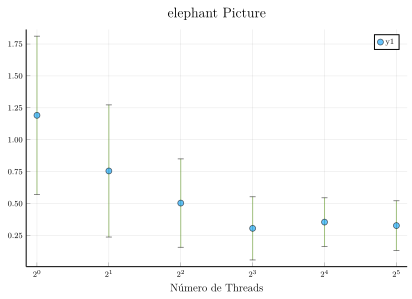

In [28]:
elephant_results = readingThreadFiles("elephant", 1024, "pth")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

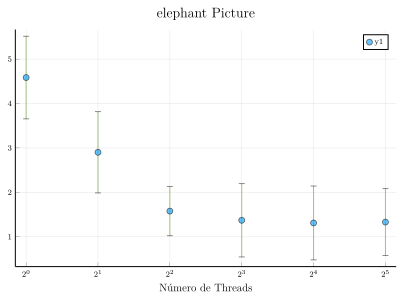

In [29]:
elephant_results = readingThreadFiles("elephant", 2048, "pth")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

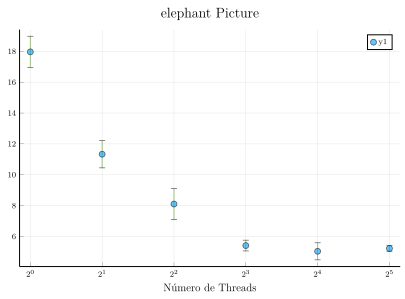

In [30]:
elephant_results = readingThreadFiles("elephant", 4096, "pth")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

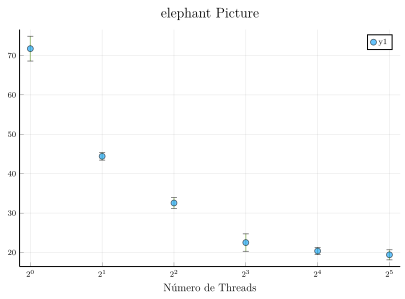

In [31]:
elephant_results = readingThreadFiles("elephant", 8192, "pth")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

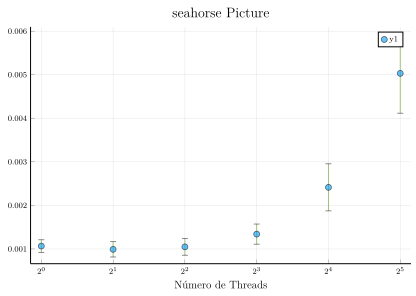

In [38]:
seahorse_results = readingThreadFiles("seahorse", 16, "pth")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

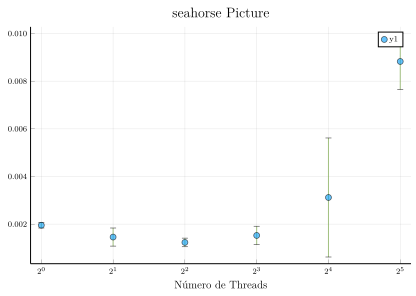

In [39]:
seahorse_results = readingThreadFiles("seahorse", 32, "pth")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

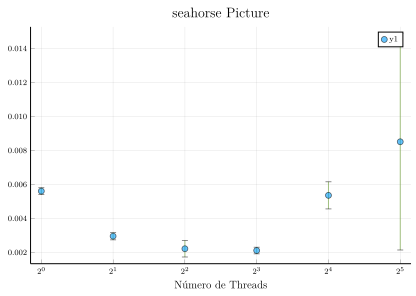

In [40]:
seahorse_results = readingThreadFiles("seahorse", 64, "pth")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

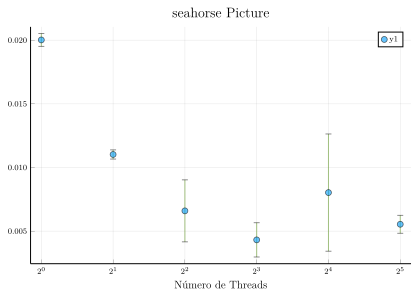

In [41]:
seahorse_results = readingThreadFiles("seahorse", 128, "pth")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

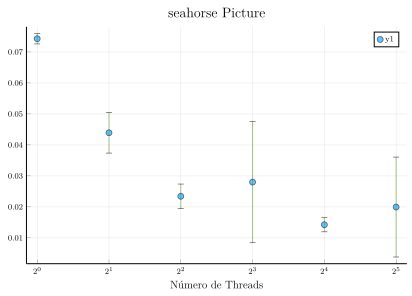

In [42]:
seahorse_results = readingThreadFiles("seahorse", 256, "pth")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

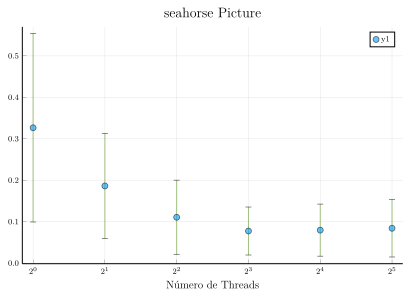

In [43]:
seahorse_results = readingThreadFiles("seahorse", 512, "pth")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

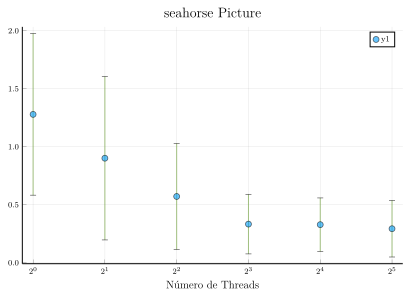

In [44]:
seahorse_results = readingThreadFiles("seahorse", 1024, "pth")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

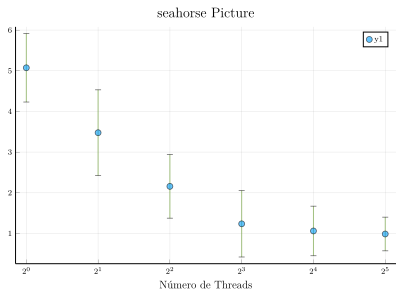

In [45]:
seahorse_results = readingThreadFiles("seahorse", 2048, "pth")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

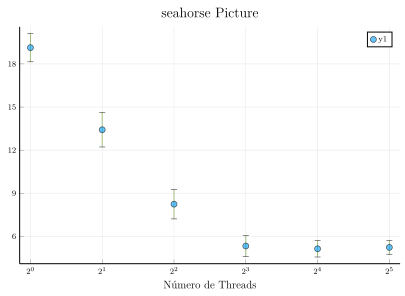

In [46]:
seahorse_results = readingThreadFiles("seahorse", 4096, "pth")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

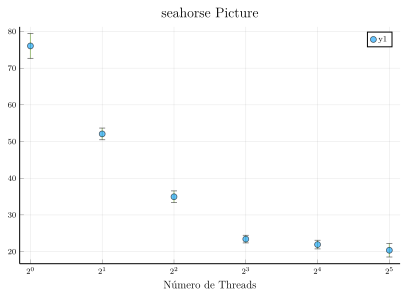

In [47]:
seahorse_results = readingThreadFiles("seahorse", 8192, "pth")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

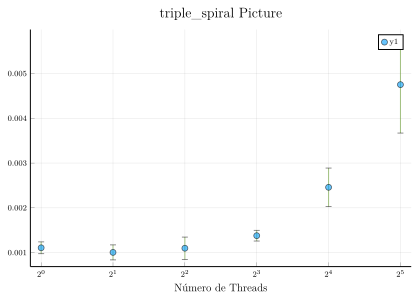

In [48]:
triple_spiral_results = readingThreadFiles("triple_spiral", 16, "pth")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

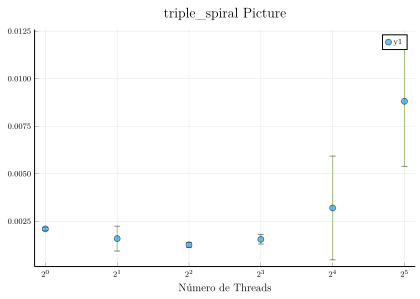

In [49]:
triple_spiral_results = readingThreadFiles("triple_spiral", 32, "pth")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

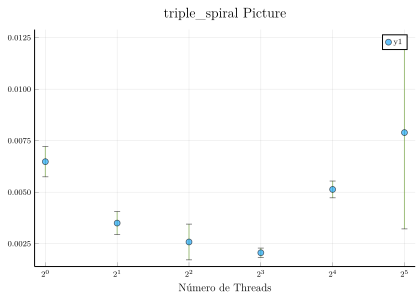

In [50]:
triple_spiral_results = readingThreadFiles("triple_spiral", 64, "pth")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

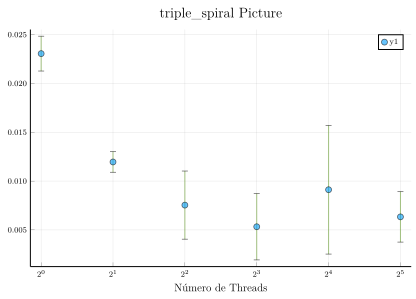

In [51]:
triple_spiral_results = readingThreadFiles("triple_spiral", 128, "pth")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

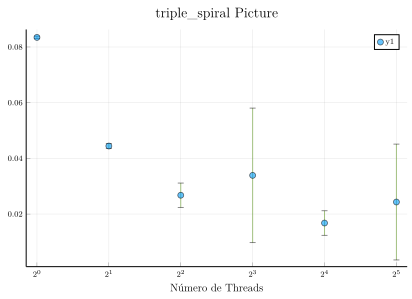

In [52]:
triple_spiral_results = readingThreadFiles("triple_spiral", 256, "pth")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

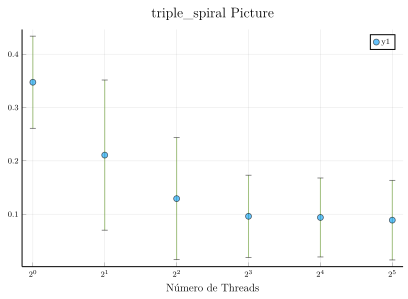

In [53]:
triple_spiral_results = readingThreadFiles("triple_spiral", 512, "pth")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

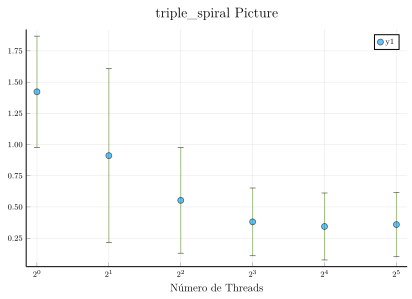

In [54]:
triple_spiral_results = readingThreadFiles("triple_spiral", 1024, "pth")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

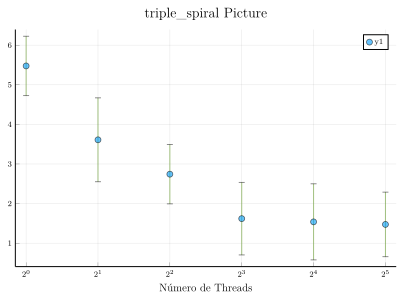

In [55]:
triple_spiral_results = readingThreadFiles("triple_spiral", 2048, "pth")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

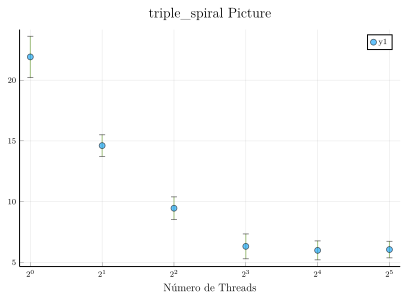

In [56]:
triple_spiral_results = readingThreadFiles("triple_spiral", 4096, "pth")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

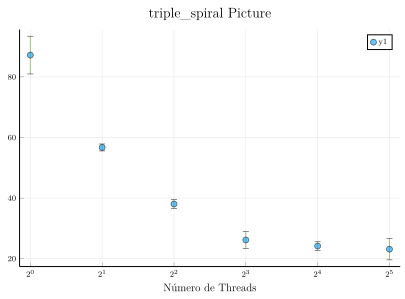

In [57]:
triple_spiral_results = readingThreadFiles("triple_spiral", 8192, "pth")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

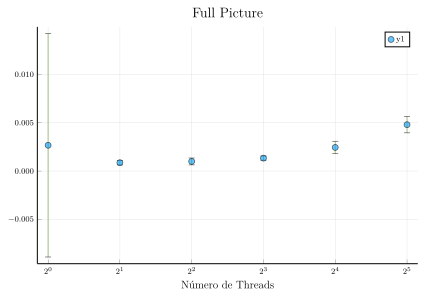

In [12]:
full_results = readingThreadFiles("full", 16, "pth")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

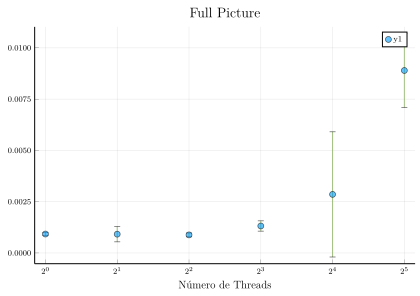

In [13]:
full_results = readingThreadFiles("full", 32, "pth")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

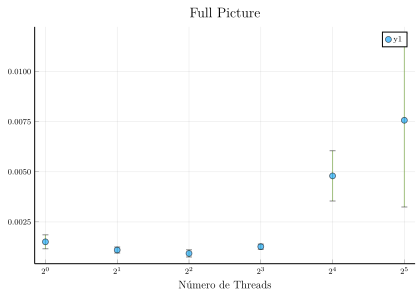

In [14]:
full_results = readingThreadFiles("full", 64, "pth")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

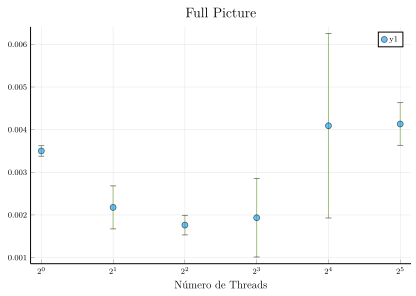

In [15]:
full_results = readingThreadFiles("full", 128, "pth")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

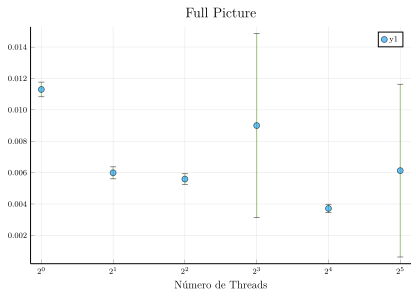

In [16]:
full_results = readingThreadFiles("full", 256, "pth")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

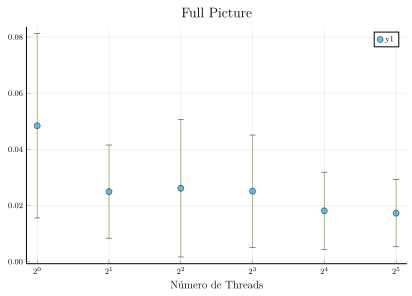

In [17]:
full_results = readingThreadFiles("full", 512, "pth")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

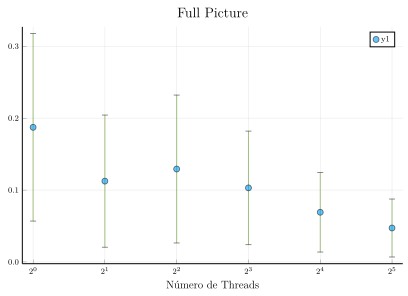

In [18]:
full_results = readingThreadFiles("full", 1024, "pth")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

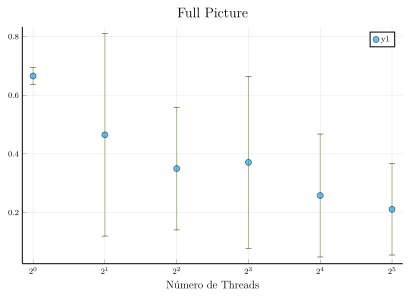

In [19]:
full_results = readingThreadFiles("full", 2048, "pth")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

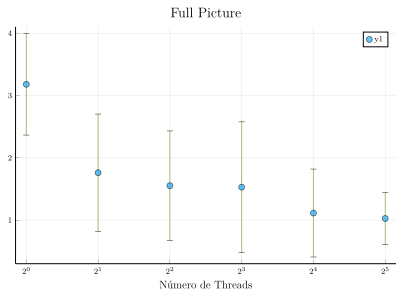

In [20]:
full_results = readingThreadFiles("full", 4096, "pth")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

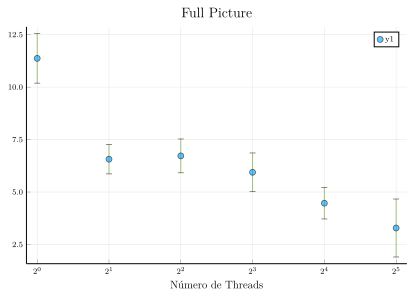

In [21]:
full_results = readingThreadFiles("full", 8192, "pth")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

#### Análise das threads

Análise das regiões


## Análise do Programa Paralelizado com OpenMP

Agora, vamos analisar o desempenho do programa paralelizado utilizando a biblioteca Pthreads. Vamos comparar as diferenças para as diferentes regiões, mas também, e principalmente, as diferenças no tempo de execução baseado no número de threads utilizadas. Vamos considerar nas análises também o tamanho da entrada.

for j in regions
    for i in 16..8192
        plot(i)
        x numero de threads
        y mean duration

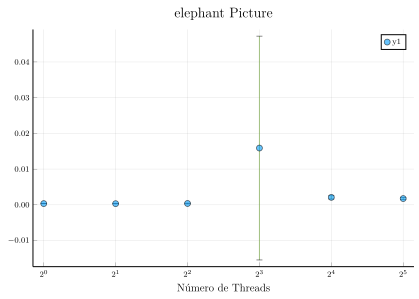

In [58]:
elephant_results = readingThreadFiles("elephant", 16, "omp")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

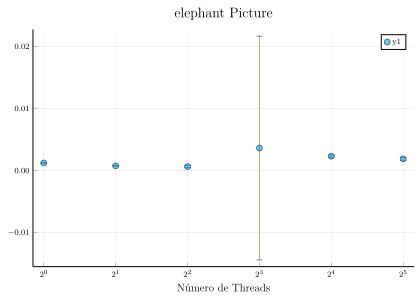

In [59]:
elephant_results = readingThreadFiles("elephant", 32, "omp")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

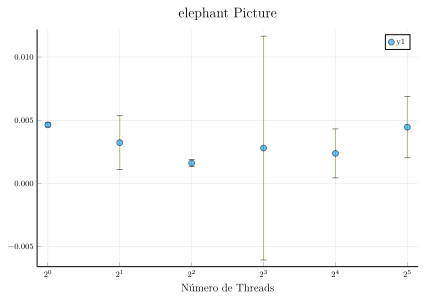

In [60]:
elephant_results = readingThreadFiles("elephant", 64, "omp")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

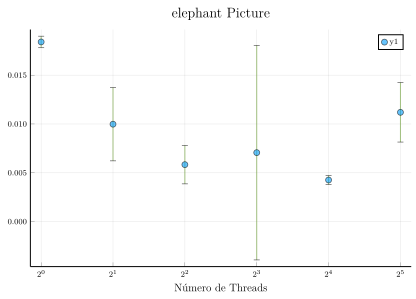

In [61]:
elephant_results = readingThreadFiles("elephant", 128, "omp")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

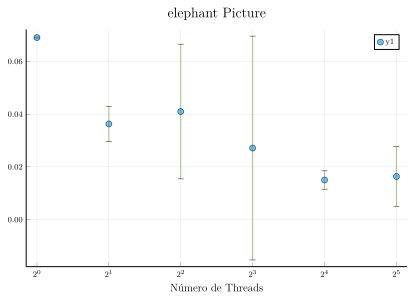

In [62]:
elephant_results = readingThreadFiles("elephant", 256, "omp")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

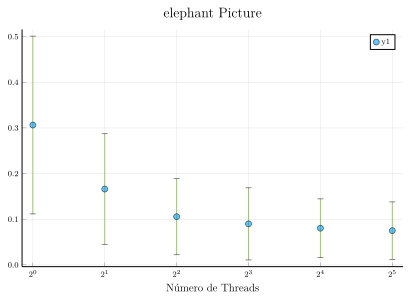

In [63]:
elephant_results = readingThreadFiles("elephant", 512, "omp")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

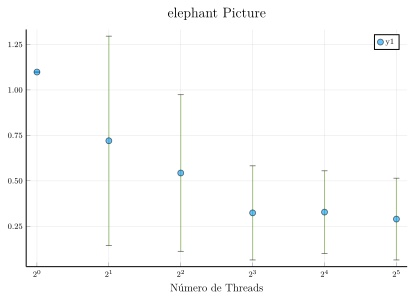

In [64]:
elephant_results = readingThreadFiles("elephant", 1024, "omp")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

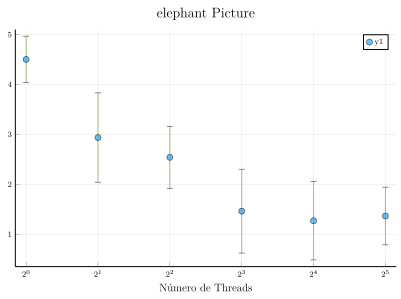

In [65]:
elephant_results = readingThreadFiles("elephant", 2048, "omp")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

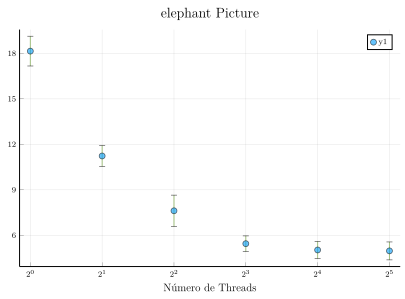

In [66]:
elephant_results = readingThreadFiles("elephant", 4096, "omp")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

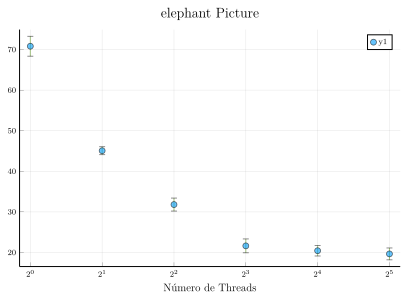

In [67]:
elephant_results = readingThreadFiles("elephant", 8192, "omp")
elephant_parsed_results = parse_thread_results(elephant_results)

plot_thread_results(elephant_parsed_results.threads, elephant_parsed_results.mean_estimate, "elephant Picture",
                    elephant_parsed_results.ci_estimate, 0, 5)

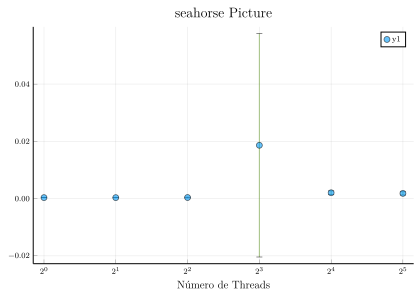

In [68]:
seahorse_results = readingThreadFiles("seahorse", 16, "omp")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

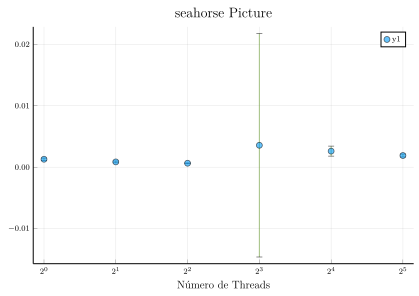

In [69]:
seahorse_results = readingThreadFiles("seahorse", 32, "omp")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

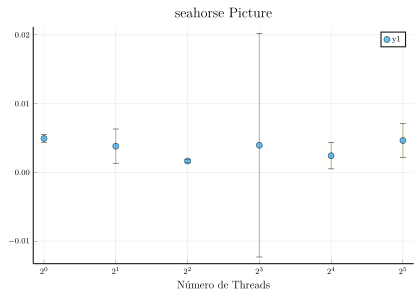

In [70]:
seahorse_results = readingThreadFiles("seahorse", 64, "omp")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

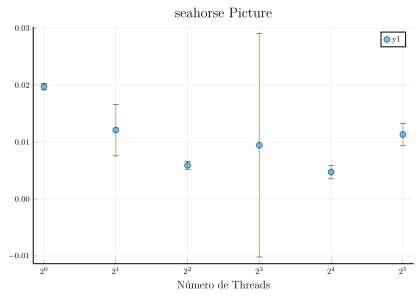

In [71]:
seahorse_results = readingThreadFiles("seahorse", 128, "omp")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

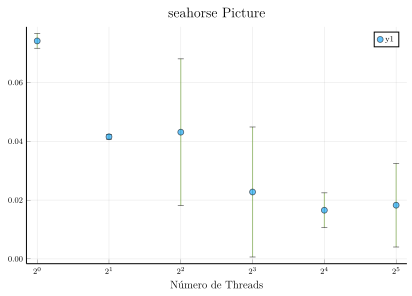

In [72]:
seahorse_results = readingThreadFiles("seahorse", 256, "omp")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

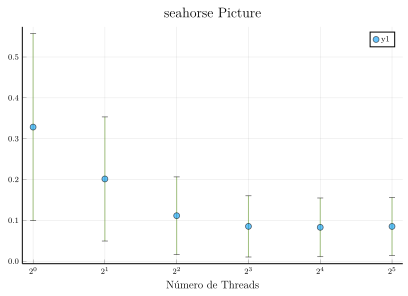

In [73]:
seahorse_results = readingThreadFiles("seahorse", 512, "omp")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

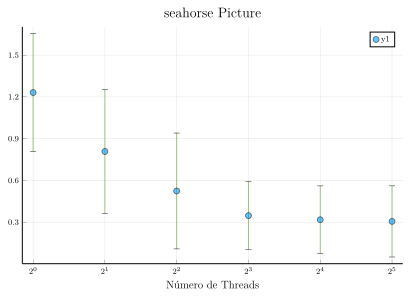

In [74]:
seahorse_results = readingThreadFiles("seahorse", 1024, "omp")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

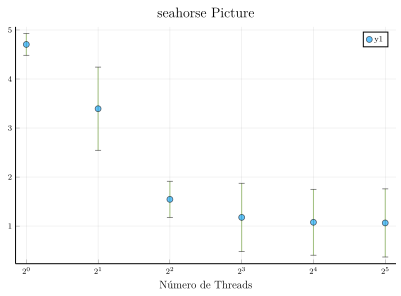

In [75]:
seahorse_results = readingThreadFiles("seahorse", 2048, "omp")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

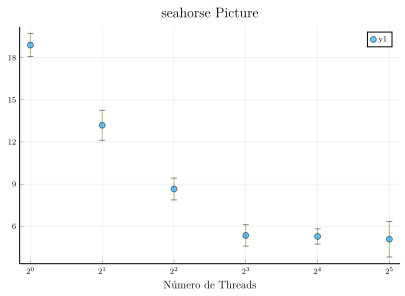

In [76]:
seahorse_results = readingThreadFiles("seahorse", 4096, "omp")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

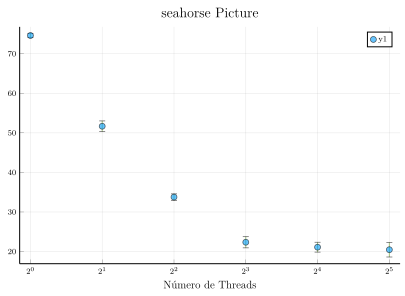

In [77]:
seahorse_results = readingThreadFiles("seahorse", 8192, "omp")
seahorse_parsed_results = parse_thread_results(seahorse_results)

plot_thread_results(seahorse_parsed_results.threads, seahorse_parsed_results.mean_estimate, "seahorse Picture",
                    seahorse_parsed_results.ci_estimate, 0, 5)

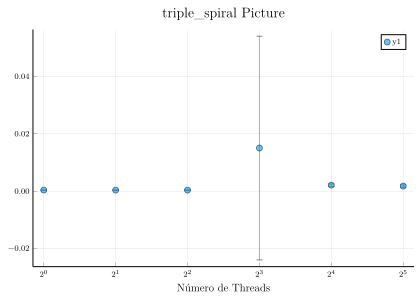

In [78]:
triple_spiral_results = readingThreadFiles("triple_spiral", 16, "omp")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

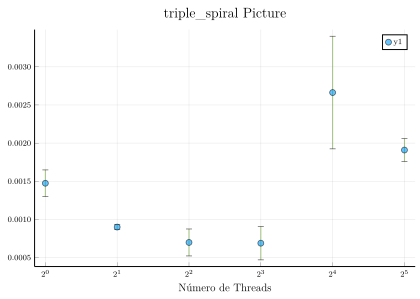

In [79]:
triple_spiral_results = readingThreadFiles("triple_spiral", 32, "omp")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

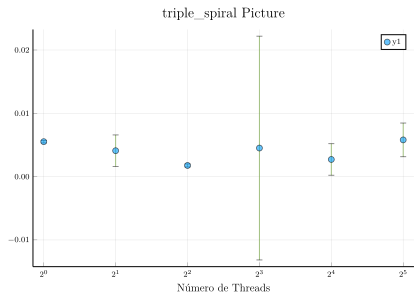

In [80]:
triple_spiral_results = readingThreadFiles("triple_spiral", 64, "omp")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

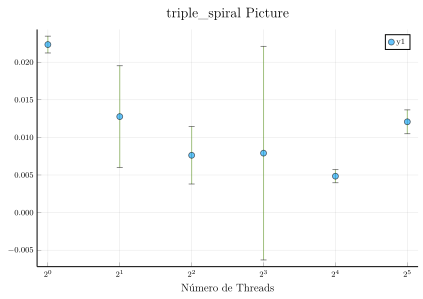

In [81]:
triple_spiral_results = readingThreadFiles("triple_spiral", 128, "omp")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

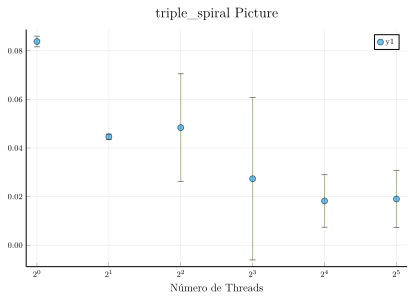

In [82]:
triple_spiral_results = readingThreadFiles("triple_spiral", 256, "omp")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

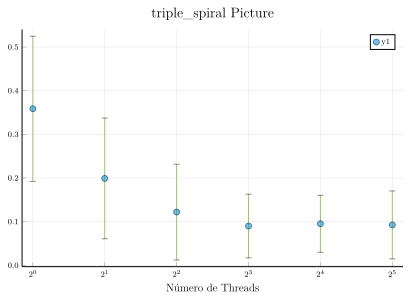

In [83]:
triple_spiral_results = readingThreadFiles("triple_spiral", 512, "omp")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

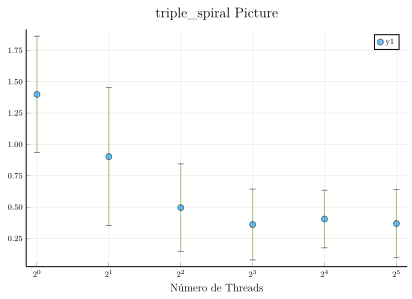

In [84]:
triple_spiral_results = readingThreadFiles("triple_spiral", 1024, "omp")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

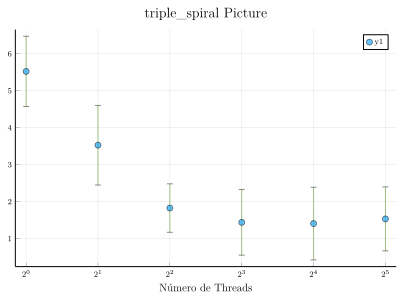

In [85]:
triple_spiral_results = readingThreadFiles("triple_spiral", 2048, "omp")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

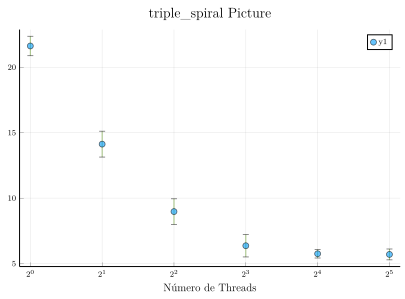

In [86]:
triple_spiral_results = readingThreadFiles("triple_spiral", 4096, "omp")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

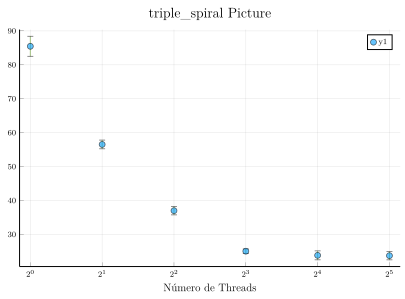

In [87]:
triple_spiral_results = readingThreadFiles("triple_spiral", 8192, "omp")
triple_spiral_parsed_results = parse_thread_results(triple_spiral_results)

plot_thread_results(triple_spiral_parsed_results.threads, triple_spiral_parsed_results.mean_estimate, "triple_spiral Picture",
                    triple_spiral_parsed_results.ci_estimate, 0, 5)

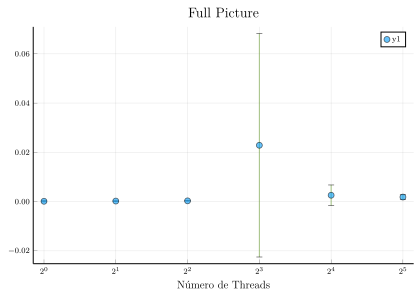

In [88]:
full_results = readingThreadFiles("full", 16, "omp")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

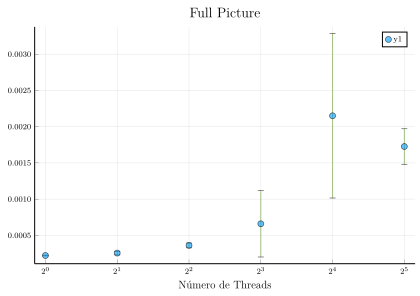

In [89]:
full_results = readingThreadFiles("full", 32, "omp")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

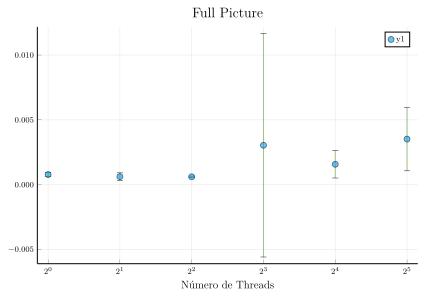

In [90]:
full_results = readingThreadFiles("full", 64, "omp")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

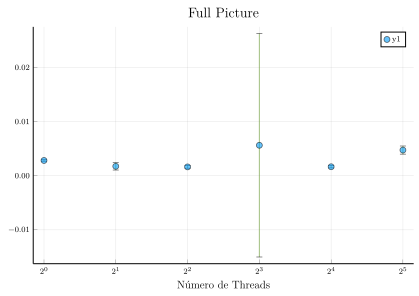

In [91]:
full_results = readingThreadFiles("full", 128, "omp")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

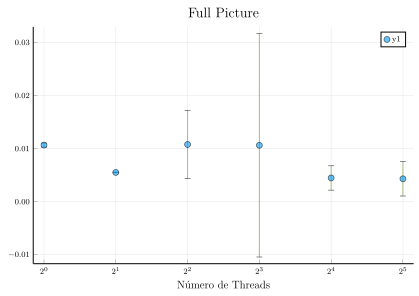

In [92]:
full_results = readingThreadFiles("full", 256, "omp")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

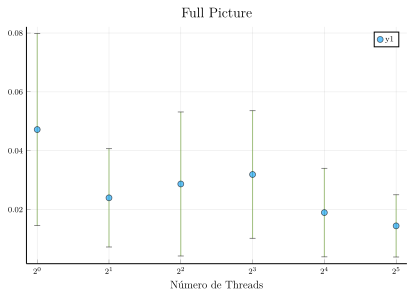

In [93]:
full_results = readingThreadFiles("full", 512, "omp")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

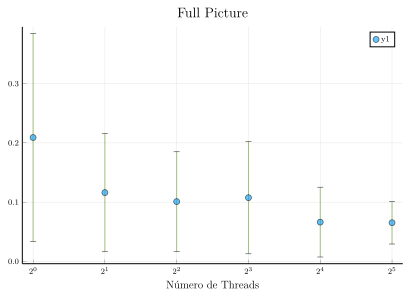

In [94]:
full_results = readingThreadFiles("full", 1024, "omp")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

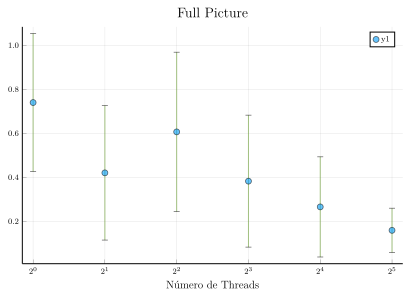

In [95]:
full_results = readingThreadFiles("full", 2048, "omp")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

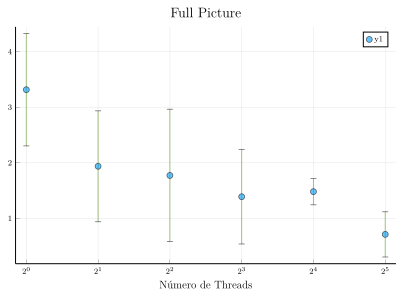

In [96]:
full_results = readingThreadFiles("full", 4096, "omp")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

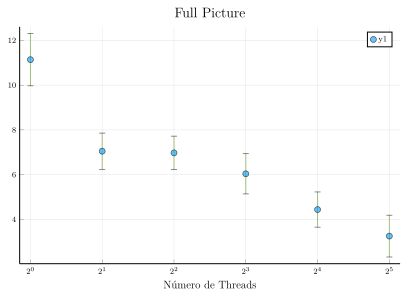

In [97]:
full_results = readingThreadFiles("full", 8192, "omp")
full_parsed_results = parse_thread_results(full_results)

plot_thread_results(full_parsed_results.threads, full_parsed_results.mean_estimate, "Full Picture",
                    full_parsed_results.ci_estimate, 0, 5)

#### Análise das threads

Análise das regiões


In [ ]:
using CSV

function save_csv_results(df, filename)
   CSV.write(string(filename, ".csv"), df) 
end

save_csv_results(parsed_results, "results")

In [ ]:
using CSV

function read_csv_results(filename)
    return CSV.read(filename)
end

read_csv_results("results.csv")